# PSF check

## Import modules

In [1]:
import copy, warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.modeling import models, fitting
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.background import MMMBackground
from photutils.detection import find_peaks
from photutils.psf import EPSFBuilder, extract_stars, EPSFFitter

## Define a function

In [2]:
def ePSF_maker(filename, mag, bit, n_maxiter=3, norm_radius=5.5,
               recentering_boxsize=5):
    '''
    filename: Name of the input FITS file.
    mag: Object magnitude.
    bit: ADC resolution.
    n_maxiter: Maximum number of iteration in ePSF analysis.
    norm_radius: Number of undersampled pixels 
                 which determines the radius for flux normalization of ePSF.
    recentering_boxsize: Number of undersampled pixels
                 which determines the box size for ePSF recentering calculation.
    '''
    
    mask_size = 25   # Edge mask size.
    ext_size  = 9    # Size of extraction window.
    n_oversample = 4 # Number of oversampling for ePSF.
#    n_maxiter    = 3 # Max. number of iteration for making ePSF.
#    mag = 12.0       # Object magnitude.
    threshold = 3000.*10.**((mag-12.0)/(-2.5))*2.**bit/2.**16
#    print("Analyzing {}...".format(filename))
    
    # Loading image.
    hdu = pf.open(filename)[0]
    data = hdu.data.astype(np.float32)
    norm = simple_norm(data, 'sqrt', percent=99.)
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.show()
    
    # Finding peaks.
    peaks_tbl = find_peaks(data, threshold=threshold)
    peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#    print(peaks_tbl)
    
    # Removing detections near edge.
    hsize = (mask_size - 1) / 2
    x = peaks_tbl['x_peak'] 
    y = peaks_tbl['y_peak'] 
    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
#    print(stars_tbl)
    
    # Subtracting background.
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
    image = copy.deepcopy(data)
    data -= mean_val
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')

    # Extracting stellar images.
    nddata = NDData(data=data)
#    print(nddata.data.shape)
    stars = extract_stars(nddata, stars_tbl, size=ext_size)
#    nrows = 10
#    ncols = 10
#    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
#    ax = ax.ravel()
#    for i in range(nrows*ncols):
#        norm = simple_norm(stars[i], 'log', percent=99.)
#        ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
#    plt.show()
        
    # Making ePSF.
    epsf_builder = EPSFBuilder(oversampling=n_oversample,
                               maxiters=n_maxiter, progress_bar=False,
                               norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                               center_accuracy=0.001)
    epsf, fitted_stars = epsf_builder(stars)
#    norm = simple_norm(epsf.data, 'log', percent=99.)
#    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (oversampled pix)')
#    plt.ylabel('Y (oversampled pix)')
#    plt.colorbar()
#    plt.show()

    return epsf

## Make ePSF

In [4]:
nplate = 11
bit = 16

filename = f'image.10.0.{nplate:02d}.{bit:2d}bit.fits'
epsf100 = ePSF_maker(filename, 10.0, bit)

filename = f'image.14.5.{nplate:02d}.{bit:2d}bit.fits'
epsf145 = ePSF_maker(filename, 14.5, bit)

## Compare the ePSFs

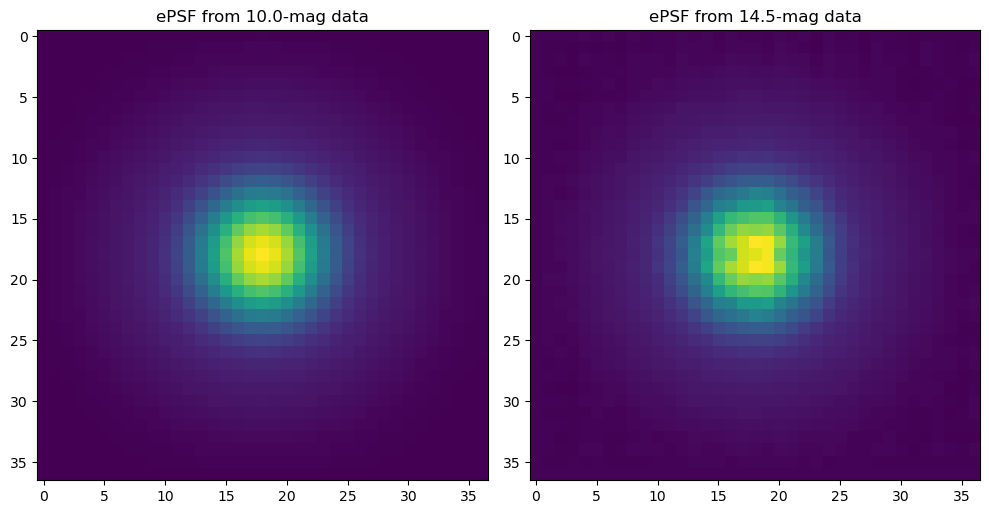

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(epsf100.data)
plt.title('ePSF from 10.0-mag data')
plt.subplot(1,2,2)
plt.imshow(epsf145.data)
plt.title('ePSF from 14.5-mag data')
plt.tight_layout()
plt.show()

14.5-mag ePSF looks dirty...